## Imports et Configuration

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import numpy as np
from PIL import Image
import time
import os
import copy

# Configuration
CONFIG = {
    'img_size': 64,          # Taille réduite pour Edge AI
    'embed_dim': 128,        # Taille vecteur latent z
    'num_classes': 3,        # 0: Alert, 1: Drowsy, 2: Distracted
    'recursion_depth': 4,    # Nombre d'itérations du TRM (n)
    'batch_size': 32,
    'lr': 1e-3,
    'epochs': 200,
    'device': torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    'save_path': 'best_trm_model.pth'
}

print(f"Utilisation du device : {CONFIG['device']}")

Utilisation du device : cuda


### Architecture TRM (Tiny Recursive Model)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# ARCHITECTURE MHA + PosEmbed + CLS Token


class SpatialVisualEmbedding(nn.Module):
    def __init__(self, output_dim):
        super().__init__()
        # On utilise GroupNorm au lieu de BatchNorm pour la stabilité sur petits batchs
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1),
            nn.GroupNorm(8, 32),
            nn.ReLU6(),
            
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.GroupNorm(8, 64),
            nn.ReLU6(),
            
            nn.Conv2d(64, output_dim, 3, stride=2, padding=1),
            nn.GroupNorm(8, output_dim),
            nn.ReLU6(),
            
            # Grille 4x4 (16 patches)
            nn.AdaptiveAvgPool2d((4, 4)) 
        )
    
    def forward(self, x):
        x = self.features(x)
        B, C, H, W = x.shape
        x = x.view(B, C, -1).permute(0, 2, 1) # [B, 16, Dim]
        return x

class AttentionTRMBlock(nn.Module):
    def __init__(self, embed_dim, num_classes, num_heads=4):
        super().__init__()
        self.attn_norm = nn.LayerNorm(embed_dim)
        
        # IMPORTANT : average_attn_weights=False pour garder l'info par tête
        self.attn = nn.MultiheadAttention(embed_dim, num_heads=num_heads, batch_first=True)
        
        self.ffn_norm = nn.LayerNorm(embed_dim)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 2),
            nn.GELU(),
            nn.Linear(embed_dim * 2, embed_dim)
        )
        self.head = nn.Linear(embed_dim, num_classes)
        
        # Gating pour contrôler l'injection
        self.gate = nn.Parameter(torch.zeros(1)) 

    def forward(self, tokens, z_prev):
        # tokens contient [CLS] + Patches avec position
        # z_prev est la mémoire récursive
        
        g = torch.sigmoid(self.gate)
        z_curr = z_prev + g * tokens # Injection contrôlée
        
        z_norm = self.attn_norm(z_curr)
        
        # Récupération de l'attention complète [B, Heads, L, L]
        attn_out, attn_weights = self.attn(z_norm, z_norm, z_norm, average_attn_weights=False)
        
        z_curr = z_curr + attn_out
        z_curr = z_curr + self.ffn(self.ffn_norm(z_curr))
        
        # Classification via le token [CLS] (indice 0)
        cls_tok = z_curr[:, 0, :] 
        y_logits = self.head(cls_tok)
        
        return z_curr, y_logits, attn_weights

class DriverTRM(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.embed_dim = config['embed_dim']
        self.H = self.W = 4 # Grille 4x4
        
        # 1. Embedding Visuel
        self.embedding = SpatialVisualEmbedding(self.embed_dim)
        
        # 2. Token [CLS] (Learnable)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, self.embed_dim))
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        
        # 3. Positional Embedding (Indispensable pour la spatialité)
        # Taille = 1 (CLS) + 16 (Patches) = 17
        self.pos_embed = nn.Parameter(torch.zeros(1, 1 + self.H*self.W, self.embed_dim))
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        
        # 4. Bloc Récursif
        self.trm_block = AttentionTRMBlock(self.embed_dim, config['num_classes'], num_heads=4)
        
    def forward(self, img):
        B = img.size(0)
        
        # Extraction des patches [B, 16, D]
        x_feat = self.embedding(img)
        
        # Ajout du CLS [B, 1, D]
        cls_tokens = self.cls_token.expand(B, -1, -1)
        
        # Concaténation -> [B, 17, D]
        tokens = torch.cat([cls_tokens, x_feat], dim=1)
        
        # AJOUT DES POSITIONS (Crucial pour que l'attention sache "où" regarder)
        tokens = tokens + self.pos_embed
        
        # Mémoire récursive initialisée à zéro
        z_curr = torch.zeros_like(tokens).to(img.device)
        
        outputs_list = []
        last_attn = None
        
        for _ in range(self.config['recursion_depth']):
            z_curr, y_logits, last_attn = self.trm_block(tokens, z_curr)
            outputs_list.append(y_logits)
            
        return outputs_list, last_attn

### Téléchargement et Préparation des Données

In [3]:
import kagglehub
import os
import glob

def download_and_prepare_data_v2():
    print("--- Téléchargement des Datasets via KaggleHub ---")
    
    # 1. Eye Dataset (Somnolence Yeux)
    eye_path = kagglehub.dataset_download("coderkr/eye-dataset")
    
    # 2. State Farm (Distraction)
    sf_path = kagglehub.dataset_download("rightway11/state-farm-distracted-driver-detection")
    
    # 3. Driver Drowsiness Dataset (DDD)
    ddd_path = kagglehub.dataset_download("ismailnasri20/driver-drowsiness-dataset-ddd")
    print(f"DDD Dataset téléchargé dans : {ddd_path}")
    
    all_image_paths = []
    all_labels = [] # 0: Alert, 1: Drowsy, 2: Distracted
    
    # --- A. Traitement State Farm (Distraction) ---
    print("\n[State Farm] Indexation...")
    sf_train_dir = os.path.join(sf_path, 'imgs', 'train')
    if os.path.exists(sf_train_dir):
        for class_folder in os.listdir(sf_train_dir):
            if class_folder.startswith('c'):
                label = 0 if class_folder == 'c0' else 2
                imgs = glob.glob(os.path.join(sf_train_dir, class_folder, '*.jpg'))
                all_image_paths.extend(imgs)
                all_labels.extend([label] * len(imgs))
                
    # --- B. Traitement Eye Dataset (Yeux) ---
    print("\n[Eye Dataset] Indexation...")
    for root, dirs, files in os.walk(eye_path):
        for dir_name in dirs:
            lname = dir_name.lower()
            label = None
            if 'open' in lname: label = 0
            elif 'closed' in lname: label = 1
            
            if label is not None:
                imgs = glob.glob(os.path.join(root, dir_name, '*.*'))
                imgs = [i for i in imgs if i.lower().endswith(('.jpg', '.png', '.jpeg'))]
                all_image_paths.extend(imgs)
                all_labels.extend([label] * len(imgs))

    # --- C. Traitement DDD (Somnolence Complète) ---
    print("\n[DDD Dataset] Indexation...")
    # Structure supposée : /Drowsy et /Non Drowsy
    for root, dirs, files in os.walk(ddd_path):
        for dir_name in dirs:
            lname = dir_name.lower()
            label = None
            if 'non' in lname: label = 0  # Non Drowsy -> Alert
            elif 'drowsy' in lname: label = 1 # Drowsy
            
            if label is not None:
                imgs = glob.glob(os.path.join(root, dir_name, '*.*'))
                imgs = [i for i in imgs if i.lower().endswith(('.jpg', '.png', '.jpeg'))]
                # On limite un peu si trop d'images pour équilibrer
                if len(imgs) > 3000: imgs = imgs[:3000]
                
                all_image_paths.extend(imgs)
                all_labels.extend([label] * len(imgs))
                print(f"  DDD {dir_name} -> Label {label}: {len(imgs)} images")

    print(f"\nTotal images : {len(all_image_paths)}")
    return all_image_paths, all_labels

# Exécution immédiate pour mettre à jour les listes
image_paths, labels = download_and_prepare_data_v2()

d:\Developpement web\TRM\Driver Drowsiness Edge AI\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


--- Téléchargement des Datasets via KaggleHub ---


100%|██████████| 2.58G/2.58G [03:06<00:00, 14.8MB/s]

Extracting files...


DDD Dataset téléchargé dans : C:\Users\anase\.cache\kagglehub\datasets\ismailnasri20\driver-drowsiness-dataset-ddd\versions\1

[State Farm] Indexation...

[Eye Dataset] Indexation...

[DDD Dataset] Indexation...
  DDD Drowsy -> Label 1: 3000 images
  DDD Non Drowsy -> Label 0: 3000 images

Total images : 23462


### Le Dataset PyTorch Réel (Fusionné)

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import torchvision.transforms as T

class RealDriverDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        
        try:
            # Chargement de l'image (RGB)
            img = Image.open(img_path).convert('RGB')
            
            if self.transform:
                img = self.transform(img)
                
            return img, torch.tensor(label, dtype=torch.long)
            
        except Exception as e:
            # Gestion basique des erreurs (fichier corrompu)
            print(f"Erreur chargement {img_path}: {e}")
            # Retourner une image noire factice pour ne pas planter le batch
            return torch.zeros((3, 64, 64)), torch.tensor(label, dtype=torch.long)

# --- Configuration des Transformations (Data Augmentation) ---
# Essentiel pour homogénéiser State Farm (Corps entier) et Eye Dataset (Gros plan)
def get_transforms(phase='train'):
    if phase == 'train':
        return T.Compose([
            T.Resize((64, 64)), # Taille d'entrée du TRM
            T.RandomHorizontalFlip(p=0.5),
            T.RandomRotation(10),
            # Simulation conditions nuit/tunnel
            T.ColorJitter(brightness=0.3, contrast=0.3), 
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    else:
        return T.Compose([
            T.Resize((64, 64)),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

### Création des DataLoaders avec les Vraies Données

In [5]:
# 1. Instanciation du Dataset complet avec les données téléchargées plus haut
# image_paths et labels proviennent de votre fonction download_and_prepare_data()
full_dataset = RealDriverDataset(
    image_paths, 
    labels, 
    transform=get_transforms('train') # On applique les augmentations (rotation, bruit, etc.)
)

print(f"Dataset créé avec {len(full_dataset)} images.")

# 2. Division Train / Validation (80% Train, 20% Val)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

# generator=torch.Generator().manual_seed(42) assure que le split est toujours le même
train_ds, val_ds = random_split(full_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

print(f"Images d'entraînement : {len(train_ds)}")
print(f"Images de validation : {len(val_ds)}")

# 3. Création des DataLoaders (Ce sont eux que 'train_model' va appeler)
# num_workers > 0 permet de charger les images en parallèle pour ne pas ralentir le GPU
# pin_memory=True accélère le transfert vers le GPU (cuda)
train_loader = DataLoader(
    train_ds, 
    batch_size=CONFIG['batch_size'], 
    shuffle=True, 
    num_workers=0, 
    pin_memory=True
)

val_loader = DataLoader(
    val_ds, 
    batch_size=CONFIG['batch_size'], 
    shuffle=False, 
    num_workers=0, 
    pin_memory=True
)

print("DataLoaders prêts !")

Dataset créé avec 23462 images.
Images d'entraînement : 18769
Images de validation : 4693
DataLoaders prêts !


### Entraînement ADAPTÉ AU MULTI-HEAD ATTENTION & Checkpointing

In [6]:
import torch.optim as optim
import time
from sklearn.metrics import f1_score
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

# --- 1. Fonctions Utilitaires ---

def calculate_entropy(probs):
    """
    Calcule l'incertitude moyenne.
    """
    epsilon = 1e-8
    entropy = -torch.sum(probs * torch.log(probs + epsilon), dim=1)
    return entropy.mean().item()

def deep_supervision_loss(outputs_list, targets, criterion):
    """
    Moyenne de la loss sur toutes les étapes de récursion.
    """
    total_loss = 0
    for output in outputs_list:
        total_loss += criterion(output, targets)
    return total_loss / len(outputs_list)

def attention_entropy_loss(attn_weights, lambda_ent=0.01):
    """
    Pénalise l'incertitude dans l'attention CLS->Patches.
    attn_weights: [B, Heads, L, L]
    """
    # On regarde seulement CLS -> Patches
    # attn_weights[:, :, 0, 1:] est de taille [B, Heads, 16]
    probs = attn_weights[:, :, 0, 1:]
    
    # Évite log(0)
    probs = probs.clamp(min=1e-9)
    
    # Entropie = - sum(p * log(p))
    entropy = -(probs * probs.log()).sum(dim=-1).mean()
    
    return lambda_ent * entropy

# --- 2. Boucle d'Entraînement Principale ---

def train_model():
    print(f"🚀 Démarrage de l'entraînement (Focus F1-Score) sur {CONFIG['device']}...")
    
    # Instanciation du modèle
    model = DriverTRM(CONFIG).to(CONFIG['device'])
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG['lr'])
    criterion = nn.CrossEntropyLoss()
    
    # Scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=5
    )
    
    # Historique complet
    history = {'train_loss': [], 'val_loss': [], 'val_acc': [], 'val_f1': [], 'val_entropy': []}
    
    # On va tracker le meilleur F1-Score pour la sauvegarde
    best_val_f1 = 0.0
    start_time = time.time()

    # En-tête du tableau
    print(f"{'Epoch':^7} | {'Train Loss':^10} | {'Val Loss':^8} | {'Val Acc':^8} | {'Val F1':^8} | {'Entropy':^7} | {'LR':^7}")
    print("-" * 95)

    for epoch in range(CONFIG['epochs']):
        # --- TRAIN ---
        model.train()
        running_loss = 0.0
        
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(CONFIG['device']), labels.to(CONFIG['device'])
            optimizer.zero_grad()
            
            # Le modèle Attention renvoie (outputs, attention)
            outputs_list, attn_weights = model(imgs)
            
            # Loss Principale (Deep Supervision) + Pénalité d'Entropie sur l'Attention
            loss_main = deep_supervision_loss(outputs_list, labels, criterion)
            loss_attn = attention_entropy_loss(attn_weights, lambda_ent=0.05)
            
            loss = loss_main + loss_attn
             
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
        avg_train_loss = running_loss / len(train_loader)
        
        # --- VALIDATION ---
        model.eval()
        val_loss = 0.0
        val_entropy_sum = 0.0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(CONFIG['device']), labels.to(CONFIG['device'])
                
                # Idem ici, on unpack le tuple
                outputs_list, _ = model(imgs)
                
                loss = deep_supervision_loss(outputs_list, labels, criterion)
                val_loss += loss.item()
                
                # Métriques sur la dernière étape de récursion
                final_logits = outputs_list[-1]
                probs = F.softmax(final_logits, dim=1)
                
                # Entropy
                val_entropy_sum += calculate_entropy(probs)
                
                preds = torch.argmax(final_logits, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        # Calcul des moyennes
        avg_val_loss = val_loss / len(val_loader)
        avg_val_entropy = val_entropy_sum / len(val_loader)
        
        # Métriques Sklearn
        val_acc = np.mean(np.array(all_preds) == np.array(all_labels))
        val_f1 = f1_score(all_labels, all_preds, average='weighted')
        
        # Mise à jour Scheduler (basé sur F1 cette fois)
        scheduler.step(val_f1)
        current_lr = optimizer.param_groups[0]['lr']
        
        # Historique
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1)
        history['val_entropy'].append(avg_val_entropy)
        
        # Sauvegarde (Checkpointing) basée sur le F1-Score
        save_msg = ""
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save(model.state_dict(), CONFIG['save_path'])
            save_msg = "--> ⭐ Saved!"
            
        print(f"{epoch+1:^7} | {avg_train_loss:^10.4f} | {avg_val_loss:^8.4f} | {val_acc:^8.4f} | {val_f1:^8.4f} | {avg_val_entropy:^7.4f} | {current_lr:.1e} {save_msg}")

    print("\nEntraînement terminé.")
    return model, history, all_labels, all_preds

# Lancement
trained_model, history, y_true, y_pred = train_model()

🚀 Démarrage de l'entraînement (Focus F1-Score) sur cuda...
 Epoch  | Train Loss | Val Loss | Val Acc  |  Val F1  | Entropy |   LR   
-----------------------------------------------------------------------------------------------
   1    |   0.3487   |  0.2838  |  0.9082  |  0.8982  | 0.2296  | 1.0e-03 --> ⭐ Saved!
   2    |   0.2825   |  0.2697  |  0.9028  |  0.9002  | 0.3593  | 1.0e-03 --> ⭐ Saved!
   3    |   0.2546   |  0.2393  |  0.9203  |  0.9136  | 0.2147  | 1.0e-03 --> ⭐ Saved!
   4    |   0.2422   |  0.2141  |  0.9248  |  0.9188  | 0.2017  | 1.0e-03 --> ⭐ Saved!
   5    |   0.2246   |  0.1918  |  0.9320  |  0.9280  | 0.2294  | 1.0e-03 --> ⭐ Saved!
   6    |   0.2005   |  0.1750  |  0.9318  |  0.9298  | 0.1530  | 1.0e-03 --> ⭐ Saved!
   7    |   0.1730   |  0.1854  |  0.9312  |  0.9280  | 0.0939  | 1.0e-03 
   8    |   0.1556   |  0.1435  |  0.9510  |  0.9500  | 0.0937  | 1.0e-03 --> ⭐ Saved!
   9    |   0.1291   |  0.1051  |  0.9631  |  0.9624  | 0.1010  | 1.0e-03 --> ⭐ Saved!


### Affichage des Résultats et Plots

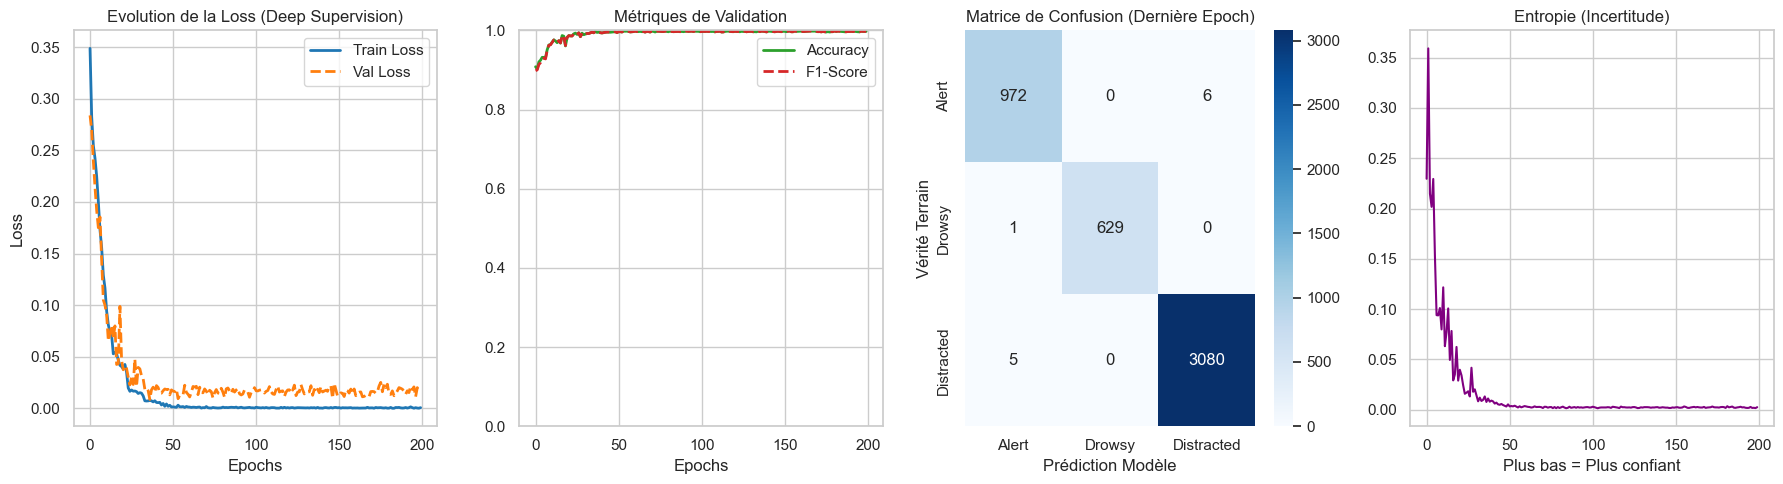


--- Rapport de Classification ---
              precision    recall  f1-score   support

       Alert       0.99      0.99      0.99       978
      Drowsy       1.00      1.00      1.00       630
  Distracted       1.00      1.00      1.00      3085

    accuracy                           1.00      4693
   macro avg       1.00      1.00      1.00      4693
weighted avg       1.00      1.00      1.00      4693



In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_results(history, y_true, y_pred, classes=['Alert', 'Drowsy', 'Distracted']):
    # CORRECTION : On force la liste des labels attendus [0, 1, 2]
    # Cela évite le crash si une classe est manquante dans les prédictions
    all_labels = range(len(classes)) 

    sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(1, 4, figsize=(18, 5))
    
    # 1. Courbes de Loss 
    ax[0].plot(history['train_loss'], label='Train Loss', color='tab:blue', linewidth=2)
    ax[0].plot(history['val_loss'], label='Val Loss', color='tab:orange', linewidth=2, linestyle='--')
    ax[0].set_title("Evolution de la Loss (Deep Supervision)")
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Loss")
    ax[0].legend()
    
    # 2. Courbes de Métriques (Accuracy & F1)
    ax[1].plot(history['val_acc'], label='Accuracy', color='tab:green', linewidth=2)
    ax[1].plot(history['val_f1'], label='F1-Score', color='tab:red', linewidth=2, linestyle='--')
    ax[1].set_title("Métriques de Validation")
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylim(0, 1.0)
    ax[1].legend()
    
    # 3. Matrice de Confusion 
    # AJOUT : paramètre 'labels' pour forcer la matrice 3x3 même si une classe manque
    cm = confusion_matrix(y_true, y_pred, labels=all_labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[2], 
                xticklabels=classes, yticklabels=classes)
    ax[2].set_title("Matrice de Confusion (Dernière Epoch)")
    ax[2].set_ylabel("Vérité Terrain")
    ax[2].set_xlabel("Prédiction Modèle")


    # 4. Entropy
    ax[3].plot(history['val_entropy'], color='purple')
    ax[3].set_title("Entropie (Incertitude)")
    ax[3].set_xlabel("Plus bas = Plus confiant")
    
    plt.tight_layout()
    plt.show()
    
    # Rapport textuel détaillé
    print("\n--- Rapport de Classification ---")
    # AJOUT : paramètres 'labels' et 'zero_division'
    print(classification_report(y_true, y_pred, target_names=classes, labels=all_labels, zero_division=0))

# Afficher les graphiques
plot_results(history, y_true, y_pred)

### Fonction de Visualisation (CLS -> Patches)

In [8]:
def visualize_cls_attention(model, dataset, index=None):
    """
    Visualise l'attention portée par le token [CLS] sur les patches de l'image.
    """
    model.eval()
    if index is None: index = np.random.randint(0, len(dataset))
    
    img_tensor, label = dataset[index]
    
    # Prépare l'image pour affichage
    img_display = img_tensor.permute(1, 2, 0).cpu().numpy()
    img_display = (img_display * 0.229 + 0.485).clip(0, 1)
    img_display = (img_display * 255).astype(np.uint8)
    
    # Inférence
    img_input = img_tensor.unsqueeze(0).to(CONFIG['device'])
    with torch.no_grad():
        _, attn_weights = model(img_input)
        
        # attn_weights: [B, Heads, 17, 17]
        # On veut: CLS (idx 0) -> Patches (idx 1 à 16)
        # On moyenne les têtes pour l'affichage global
        cls_attn = attn_weights[0, :, 0, 1:] # [Heads, 16]
        cls_attn = cls_attn.mean(dim=0)      # [16] (Moyenne sur les têtes)
        
        # Reshape en grille 4x4
        attn_grid = cls_attn.view(4, 4).cpu().numpy()

    # Upscaling pour overlay
    heatmap = cv2.resize(attn_grid, (64, 64), interpolation=cv2.INTER_CUBIC)
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    overlay = cv2.addWeighted(cv2.cvtColor(img_display, cv2.COLOR_RGB2BGR), 0.6, heatmap_color, 0.4, 0)
    
    # Affichage
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1); plt.imshow(img_display); plt.title("Originale")
    plt.subplot(1, 2, 2); plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)); plt.title("Attention [CLS]")
    plt.show()

### Visualisation de l'Attention

Exemples de visualisations d'attention :


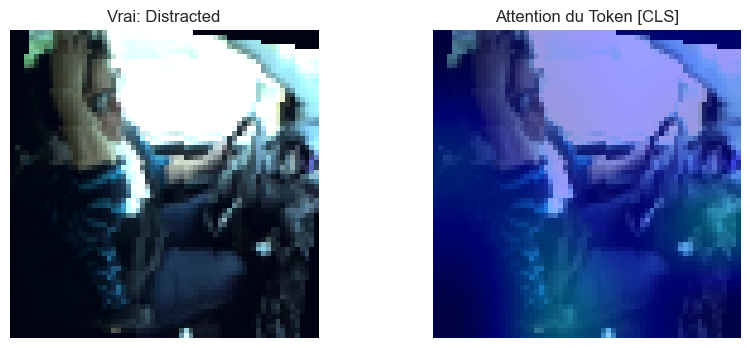

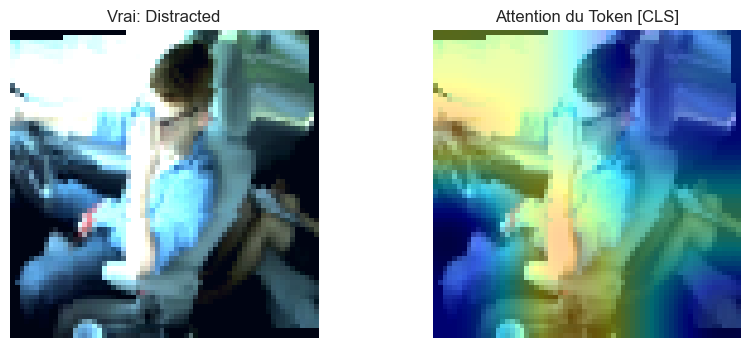

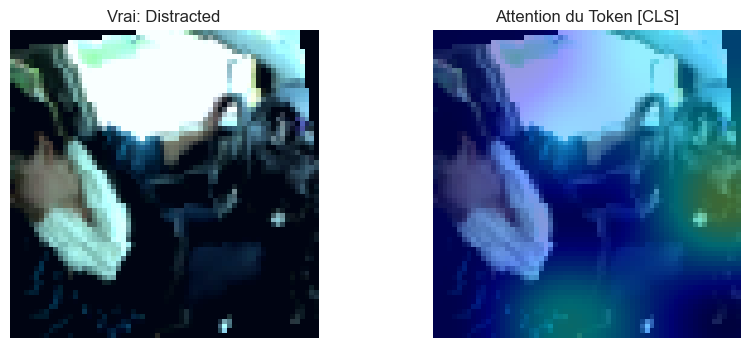

In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def visualize_attention(model, dataset, index=None):
    model.eval()
    if index is None: index = np.random.randint(0, len(dataset))
    
    img_tensor, label = dataset[index]
    
    # Préparation image pour affichage
    img_display = img_tensor.permute(1, 2, 0).cpu().numpy()
    img_display = (img_display * 0.229 + 0.485).clip(0, 1)
    img_display = (img_display * 255).astype(np.uint8)
    
    img_input = img_tensor.unsqueeze(0).to(CONFIG['device'])
    
    with torch.no_grad():
        # Le modèle retourne (outputs, attn_weights)
        _, attn_weights = model(img_input)
        
        # attn_weights shape est maintenant : [Batch, Heads, 17, 17]
        # (car 1 CLS + 16 Patches = 17 tokens)
        
        # On veut voir ce que le CLS (l'arbitre) regarde dans l'image.
        # Index 0 = CLS. Indices 1: = Les Patches de l'image.
        
        # On prend : Batch 0, Toutes les têtes, Ligne 0 (CLS), Colonnes 1 à fin (Patches)
        cls_attn = attn_weights[0, :, 0, 1:] # Shape [Heads, 16]
        
        # On fait la moyenne sur les têtes d'attention
        cls_attn = cls_attn.mean(dim=0) # Shape [16]
        
        # Maintenant on a bien 16 valeurs qu'on peut remettre en 4x4
        attn_grid = cls_attn.view(4, 4).cpu().numpy()

    # Upscaling et Colorisation
    heatmap = cv2.resize(attn_grid, (64, 64), interpolation=cv2.INTER_CUBIC)
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    # Overlay
    overlay = cv2.addWeighted(cv2.cvtColor(img_display, cv2.COLOR_RGB2BGR), 0.6, heatmap_color, 0.4, 0)
    
    # Affichage
    classes = {0: "Alert", 1: "Drowsy", 2: "Distracted"}
    
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img_display)
    plt.title(f"Vrai: {classes[label.item()]}")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.title("Attention du Token [CLS]")
    plt.axis('off')
    plt.show()

# Test
print("Exemples de visualisations d'attention :")
for _ in range(3):
    visualize_attention(trained_model, val_ds)

### Chargement du meilleur modèle pour inférence

In [ ]:
def load_best_model():
    print(f"Chargement du meilleur modèle depuis : {CONFIG['save_path']}")
    
    # 1. Recréer l'architecture
    model = DriverTRM(CONFIG)
    
    # 2. Charger les poids
    model.load_state_dict(torch.load(CONFIG['save_path'], map_location=CONFIG['device']))
    model.to(CONFIG['device'])
    model.eval()
    
    print("Modèle chargé avec succès. Prêt pour l'inférence Edge.")
    return model

best_model = load_best_model()

Chargement du meilleur modèle depuis : best_trm_model.pth
Modèle chargé avec succès. Prêt pour l'inférence Edge.
